# Building a MovieLens Recommender System

We will build our own recommendation system using the [MovieLens](https://movielens.org/home) dataset in Python.

### What is MovieLens?

MovieLens is a recommender system that was developed by GroupLens, a computer science research lab at the University of Minnesota. It recommends movies to its users based on their movie ratings. It is also a dataset that is widely used in research and teaching contexts. 

### Step 1: Import Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load Data

In [3]:
ratings = pd.read_csv('./data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies = pd.read_csv('./data/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Step 3: Exploratory Data Analysis

In [5]:
n_ratings = ratings.shape[0]   # len(ratings)
n_movies = movies.shape[0]     # len(movies)
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9742
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.35


### What is the distribution of movie ratings?

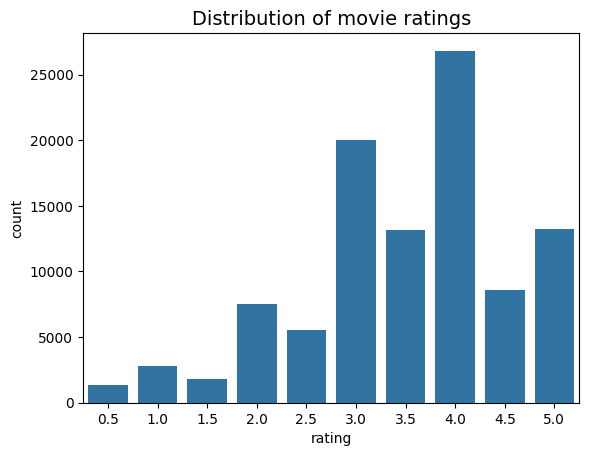

In [6]:
sns.countplot(x='rating', data=ratings)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [7]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

Mean global rating: 3.5.


In [8]:
mean_ratings = ratings.groupby('userId')['rating'].mean()
# calculates the average rating for each user by grouping the ratings DataFrame by the userId column and then computing the mean of the rating column 
# for each user. The result is a Pandas Series where the index represents the userId and the values are the corresponding average ratings.
print(mean_ratings)
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

userId
1      4.366379
2      3.948276
3      2.435897
4      3.555556
5      3.636364
         ...   
606    3.657399
607    3.786096
608    3.134176
609    3.270270
610    3.688556
Name: rating, Length: 610, dtype: float64
Mean rating per user: 3.66.


### Which movies are most frequently rated?

In [9]:
movie_ratings = ratings.merge(movies, on = 'movieId')
# combines two tables, ratings and movies, based on the movieId they share.creates a new table that includes both ratings and details of each movie.
movie_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [10]:
movie_ratings['title'].value_counts()[0:10]
# counts how many times each movie title appears in the movie_ratings DataFrame and returns the top 10 most frequent titles

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

Forrest Gump, Shawshank Redemption, and Pulp Fiction have the most ratings.

### What are the lowest and highest rated movies? 

Which movie has the lowest and highest average rating?

In [11]:
mean_ratings = ratings.groupby('movieId')['rating'].mean()
lowest_rated = mean_ratings.idxmin()

movies[movies['movieId'] ==  lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


`Gypsy` has the lowest average rating.

In [12]:
highest_rated = mean_ratings.idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


How many ratings does `Lamerica` have?

In [13]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


`Lamerica` may be the "highest" rated movie, but it only has 2 ratings. A better approach for evaluating movie popularity is to do look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average

[Bayesian Average](https://en.wikipedia.org/wiki/Bayesian_average) is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. 

- $C$ represents "the typical data set size". In this case, $C$ will be the average number of ratings for a given movie.
- $m$ represents the average rating across all movies 

In [14]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count','mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [15]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings): #Input is pandas series
    bayesian_avg = ( C*m + ratings.sum() ) / ( C + ratings.count() ) 
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


Let's test our `bayesian_avg` function out on `Lamerica`:

In [16]:
lamerica = pd.Series([5,5])
bayesian_avg(lamerica)

3.543

`Lamerica`'s average Bayesian rating is 3.5. 

Let's now apply `bayesian_avg` to all movies in our dataset.

In [17]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index() 
# calculates the Bayesian average for each movie by applying bayesian_avg fn to the rating column after grouping the data by movieId
# reset_index() creates df
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
bayesian_avg_ratings

,movieId,bayesian_avg
0,1,3.891
1,2,3.417
2,3,3.260
3,4,2.898
4,5,3.105
...,...,...
9719,193581,3.327
9720,193583,3.283
9721,193585,3.283
9722,193587,3.283


In [18]:
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.891
1,2,110,3.431818,3.417
2,3,52,3.259615,3.260
3,4,7,2.357143,2.898
4,5,49,3.071429,3.105
...,...,...,...,...
9719,193581,1,4.000000,3.327
9720,193583,1,3.500000,3.283
9721,193585,1,3.500000,3.283
9722,193587,1,3.500000,3.283


In [19]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
# movies[['movieId', 'title']] - creates new DF which takes the 2 columns
# double brackets [[]] is to select multiple columns from the movies DataFrame while maintaining the DataFrame structure
# both movie_stats and movies dataframes have a column called movieId. Since movieId is common in both, pandas used it as the join key by default.
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


Using the Bayesian average, we see that `Shawshank Redemption`, `The Godfather`, and `The Usual Suspects` are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

In [20]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


With Bayesian averaging, it looks like `Speed 2: Cruise Control`, `Battlefield Earth`, and `Godzilla` are the worst rated movies. `Gypsy` isn't so bad after all.

### A Glimpse at Movie Genres

The movies dataset needs to be cleaned in two ways:

- `genres` is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- `title` currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

In [21]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [22]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|')) # list is created in genres
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


**How many movie genres are there?**

In [23]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres) #as genres itself contains list
# Counts the frequency of each genre in the 'genres' column of the movies DataFrame using a generator expression.

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [24]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


The top 5 genres are: `Drama`, `Comedy`, `Thriller`, `Action` and `Romance`.

Let's also visualize genres popularity with a barplot.

In [25]:
genre_frequency_df = pd.DataFrame([genre_frequency])
#The square brackets [genre_frequency] create a list with a single element, which is the Counter object. 
#This is necessary because the pd.DataFrame() constructor expects an iterable (like a list) to create a DataFrame.
genre_frequency_df

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1263,611,664,3756,779,1596,4361,1828,1199,1894,978,573,980,382,334,440,158,167,87,34


In [26]:
genre_frequency_df = genre_frequency_df.T.reset_index()  # Transpose and adds index
genre_frequency_df.columns = ['genre', 'count']  # Rename the columns
genre_frequency_df

,genre,count
0,Adventure,1263
1,Animation,611
2,Children,664
3,Comedy,3756
4,Fantasy,779
5,Romance,1596
6,Drama,4361
7,Action,1828
8,Crime,1199
9,Thriller,1894


C:\Users\Mukhi2206\AppData\Local\Temp\ipykernel_7484\2564277047.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genre' , y='count' , data=genre_frequency_df.sort_values(by = 'count' , ascending = False), palette = 'viridis')


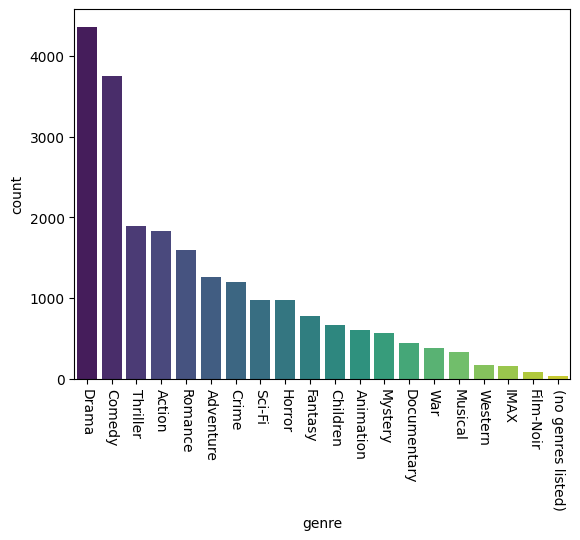

In [27]:
sns.barplot(x='genre' , y='count' , data=genre_frequency_df.sort_values(by = 'count' , ascending = False), palette = 'viridis')
plt.xticks(rotation=270)
plt.show()

### Step 4: Data Pre-processing

We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things. 

The `create_X()` function outputs a sparse matrix $X$ with four mapper dictionaries:

- **user_mapper**: maps user id to user index
- **movie_mapper**: maps movie id to movie index
- **user_inv_mapper**: maps user index to user id
- **movie_inv_mapper**: maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

Our $X$ (user-item) matrix is a [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) which stores the data sparsely.

In [28]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [29]:
print(X)

  (0, 0)	4.0
  (0, 2)	4.0
  (0, 5)	4.0
  (0, 43)	5.0
  (0, 46)	5.0
  (0, 62)	3.0
  (0, 89)	5.0
  (0, 97)	4.0
  (0, 124)	5.0
  (0, 130)	5.0
  (0, 136)	5.0
  (0, 184)	5.0
  (0, 190)	3.0
  (0, 197)	5.0
  (0, 201)	4.0
  (0, 224)	5.0
  (0, 257)	3.0
  (0, 275)	3.0
  (0, 291)	5.0
  (0, 307)	4.0
  (0, 314)	4.0
  (0, 320)	5.0
  (0, 325)	4.0
  (0, 367)	3.0
  (0, 384)	4.0
  :	:
  (609, 9238)	5.0
  (609, 9246)	4.5
  (609, 9256)	4.0
  (609, 9268)	5.0
  (609, 9274)	3.5
  (609, 9279)	3.5
  (609, 9282)	3.0
  (609, 9288)	3.0
  (609, 9304)	3.0
  (609, 9307)	2.5
  (609, 9312)	4.5
  (609, 9317)	3.0
  (609, 9324)	3.0
  (609, 9339)	4.0
  (609, 9341)	4.0
  (609, 9348)	3.5
  (609, 9371)	3.5
  (609, 9372)	3.5
  (609, 9374)	5.0
  (609, 9415)	4.0
  (609, 9416)	4.0
  (609, 9443)	5.0
  (609, 9444)	5.0
  (609, 9445)	5.0
  (609, 9485)	3.0


In [30]:
X.shape

(610, 9724)

In [31]:
user_mapper # OTHER 3 ALSO SAME

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 91: 90,
 92: 91,
 93: 92,
 94: 93,
 95: 94,
 96: 95,
 97: 96,
 98: 97,
 99: 98,
 100: 99,
 101: 100,
 102: 101,
 103: 102,
 104: 103,
 105: 104,
 106: 105,
 107: 106,
 108: 107,
 109: 108,
 110: 109,
 111: 11

Our `X` matrix contains 610 users and 9724 movies.

### Evaluating sparsity

In [32]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz # Non empty elements count
sparsity = n_ratings/n_total
print(n_total,n_ratings)
print(f"Matrix sparsity: {round(sparsity*100,2)}%")
# Anything above 1 is good

5931640 100836
Matrix sparsity: 1.7%


`csr_matrix.nnz` counts the stored values in our sparse matrix. The rest of our cells are empty.

The **cold start problem** is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.

In [33]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

610

In [34]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [35]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [36]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


C:\Users\Mukhi2206\AppData\Local\Temp\ipykernel_7484\3364525973.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
C:\Users\Mukhi2206\AppData\Local\Temp\ipykernel_7484\3364525973.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_movie, shade=True)


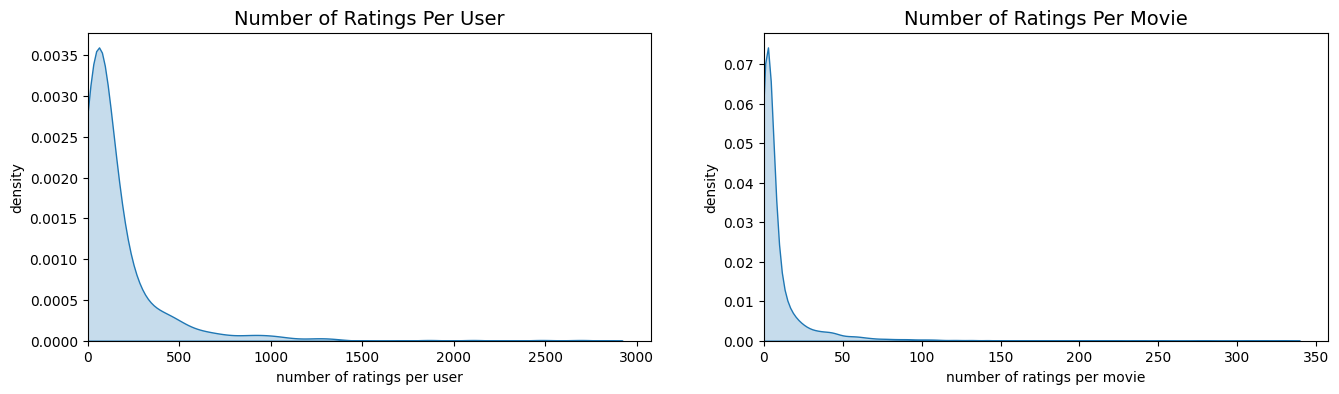

In [37]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

### Step 5: Item-item Recommendations with k-Nearest Neighbors

We are going to find the $k$ movies that have the most similar user engagement vectors for movie $i$.

In [38]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

Explanation of Above:
1. Importing the NearestNeighbors class
from sklearn.neighbors import NearestNeighbors
NearestNeighbors is imported from sklearn, which is used to compute the nearest neighbors between vectors. This algorithm compares each vector (representing movies in this case) to find its closest neighbors based on a similarity metric.

2. Defining the function
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
This defines a function that retrieves the k most similar movies to a given movie_id based on some distance metric (cosine by default).
The parameters:
movie_id: ID of the target movie.
X: A matrix (typically user-movie interaction data), where rows/columns represent users/movies or vice versa.
movie_mapper and movie_inv_mapper: Dictionaries that allow us to convert between movie IDs and their indices in matrix X.
k: The number of similar movies to return.
metric: The distance metric used to determine similarity. cosine is common because it captures similarity in direction (angle) rather than magnitude.

3. Transposing the matrix
    X = X.T
Transposes the matrix X, so that movies become rows (vectors). If the original matrix had users as rows and movies as columns, transposing allows us to compute similarities between movies rather than users.

4. Prepare to store neighbors
    neighbour_ids = []
Initializes an empty list to store the IDs of movies similar to the input movie.

5. Get the movie's index
    movie_ind = movie_mapper[movie_id]
The function retrieves the movie’s index (movie_ind) using the movie_mapper dictionary. This index corresponds to the row in X representing the movie’s vector.

6. Extract the vector of the target movie
    movie_vec = X[movie_ind]
Retrieves the movie’s feature vector from the transposed matrix X. This vector could represent, for example, the movie's interactions with different users or its features (e.g., genre, ratings).

7. Reshape the vector if needed
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
Ensures the vector is in the correct shape for the nearest neighbors algorithm. The reshape function converts it into a 2D array with 1 row, which is required for kneighbors.

8. Initialize the kNN model
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
Initializes the kNN algorithm:
n_neighbors=k+1: We add 1 because the closest movie to a given movie is usually itself, which we will later remove from the results.
algorithm="brute": Brute force checks all pairs of distances, which can be slower but works well with cosine similarity and dense data.
metric=metric: The distance metric, where "cosine" measures similarity between two vectors based on the cosine of the angle between them. Other metrics (like Euclidean) could be used.

9. Fit the kNN model
    kNN.fit(X)
Fits the kNN model to the matrix X. The kNN algorithm will now compute the pairwise distances (based on the specified metric) between all movie vectors in X.

10. Find the nearest neighbors
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
kneighbors computes the nearest neighbors for the movie’s vector (movie_vec). It returns the indices of the closest vectors (movies) in the matrix X. We set return_distance=False because we only care about the indices of the neighbors, not the actual distances.

11. Extract and store the neighbors
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
Iterates through the first k nearest neighbors:
neighbour.item(i): Extracts the index of the ith neighbor from the neighbour array.
movie_inv_mapper[n]: Maps the neighbor's index back to its original movie ID using movie_inv_mapper.
Adds each similar movie's ID to the neighbour_ids list.

12. Remove the original movie from the results
    neighbour_ids.pop(0)
Removes the first neighbor, which is the original movie itself. Since we’re interested in finding "other" similar movies, we discard the first result.

13. Return the similar movie IDs
    return neighbour_ids
Returns the list of similar movie IDs (neighbour_ids). These IDs correspond to the top k movies that are most similar to the input movie according to the kNN model and the specified distance metric.
Additional Notes:
Cosine similarity: It measures the cosine of the angle between two vectors. If the angle is small (closer to 0 degrees), the vectors are considered similar.
Brute-force kNN: In this case, brute force means checking the distances between all pairs of movies in the matrix X. Though not the most efficient, it’s effective when data is not too large or when a more advanced method isn't needed.
This function, when executed, returns a list of k movie IDs that are most similar to the input movie based on user interaction or content.

`find_similar_movies()` takes in a `movieId` and `X` matrix, and outputs a list of $k$ movies that are similar to the `movieId` of interest.

Let's see how it works in action. We will first create another mapper that maps movieId to title so that our results are interpretable.

In [39]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

`find_similar_movies()` returns a list of `movieId`'s that are most similar to your movie of interest. Let's convert these id's to titles so that we can interpret our results. To make things easier, we will create a dictionary that maps `movieId` to `title`.

In [41]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


The results above show the 10 movies that are most similar to Toy Story. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not used in this approach.

In [42]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)


### Step 6: Handling the cold-start problem

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the **cold start problem**. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

First, we need to convert the `genres` column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1.

In [43]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [48]:
genres = set(g for G in movies['genres'] for g in G) # Set : Only Unique elements
# for G in movies['genres']: This iterates over each entry in genres column. Each entry (G) is expected to be a list of genres for a particular movie.
# for g in G: This inner loop iterates over each genre (g) in the list of genres (G) for the current movie.
print(genres)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
# The transform method is applied to the genres column of the movies DF. iT allows you to apply a function to each element in the series and return a series of the same length.
# movies[g] This creates a new column in the movies DF for each genre. The name of the column will be the genre (eg: movies['Action'], movies['Drama'])
# If g is found in x, the expression evaluates to True, which is  converted to 1 (using int()). If g is not found, 0.
    
movie_genres = movies.drop(columns=['movieId', 'title','genres'])

{'Drama', 'Mystery', 'Musical', '(no genres listed)', 'Film-Noir', 'Western', 'Documentary', 'Children', 'Horror', 'Adventure', 'Animation', 'Crime', 'Sci-Fi', 'Thriller', 'Action', 'War', 'IMAX', 'Comedy', 'Fantasy', 'Romance'}


In [51]:
movie_genres.head()

,Drama,Mystery,Musical,(no genres listed),Film-Noir,Western,Documentary,Children,Horror,Adventure,Animation,Crime,Sci-Fi,Thriller,Action,War,IMAX,Comedy,Fantasy,Romance
0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [53]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres) # Cosine similarity within itself
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


In [54]:
cosine_sim

array([[1.        , 0.77459667, 0.31622777, ..., 0.        , 0.31622777,
        0.4472136 ],
       [0.77459667, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 1.        , ..., 0.        , 0.        ,
        0.70710678],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.4472136 , 0.        , 0.70710678, ..., 0.        , 0.        ,
        1.        ]])

In [55]:
cosine_sim[1]

array([0.77459667, 1.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

### Creating a movie finder function

In [58]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

Let's test this out with our Jumanji example. 

In [59]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

To get relevant recommendations for `Jumanji`, we need to find its index in the cosine simialrity matrix. To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix.

Let's create a movie index dictionary called `movie_idx` where the keys are movie titles and values are movie indices:

In [60]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


Using this handy `movie_idx` dictionary, we know that Jumanji is represented by index 1 in our matrix. Let's get the top 10 most similar movies to Jumanji.

In [61]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores

[(1, 1.0000000000000002),
 (53, 1.0000000000000002),
 (109, 1.0000000000000002),
 (767, 1.0000000000000002),
 (1514, 1.0000000000000002),
 (1556, 1.0000000000000002),
 (1617, 1.0000000000000002),
 (1618, 1.0000000000000002),
 (1799, 1.0000000000000002),
 (3574, 1.0000000000000002),
 (6075, 1.0000000000000002),
 (6389, 1.0000000000000002),
 (6629, 1.0000000000000002),
 (6655, 1.0000000000000002),
 (6751, 1.0000000000000002),
 (7426, 1.0000000000000002),
 (7478, 1.0000000000000002),
 (8230, 1.0000000000000002),
 (8641, 1.0000000000000002),
 (8719, 1.0000000000000002),
 (8800, 1.0000000000000002),
 (9294, 1.0000000000000002),
 (9336, 1.0000000000000002),
 (9565, 1.0000000000000002),
 (701, 0.8660254037844388),
 (1357, 0.8660254037844388),
 (1505, 0.8660254037844388),
 (1565, 0.8660254037844388),
 (1577, 0.8660254037844388),
 (2539, 0.8660254037844388),
 (3230, 0.8660254037844388),
 (3336, 0.8660254037844388),
 (4014, 0.8660254037844388),
 (4424, 0.8660254037844388),
 (4483, 0.866025403784

`similar_movies` is an array of indices that represents Jumanji's top 10 recommendations. We can get the corresponding movie titles by either creating an inverse movie_idx mapper or using iloc on the title column of the movies dataframe.

In [62]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


3114    Greatest Story Ever Told, The (1965)
648                    Chain Reaction (1996)
780                        Cinderella (1950)
2355                      Toy Story 2 (1999)
788          Bedknobs and Broomsticks (1971)
1073                    Jerry Maguire (1996)
34                       It Takes Two (1995)
1265                    Sliding Doors (1998)
367                        Blown Away (1994)
Name: title, dtype: object

Cool! These recommendations seem pretty relevant and similar to Jumanji. The first 5 movies are family-friendly films from the 90s.

We can test our recommender further with other movie titles. For your convenience, let's package the steps into a single function which takes in the movie title of interest and number of recommendations.

In [63]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [64]:
get_content_based_recommendations('toy story', 5)

Because you watched Toy Story (1995):
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object


### Step 7: Dimensionality Reduction with Matrix Factorization (advanced)

Matrix factorization (MF) is a linear algebra technique that can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

- user-factor matrix (n_users, k)
- item-factor matrix (k, n_items)

We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each latent feature $k$ represents. However, we could imagine that one latent feature may represent users who like romantic comedies from the 1990s, while another latent feature may represent movies which are independent foreign language films.

$$X_{mn}\approx P_{mk}\times Q_{nk}^T = \hat{X} $$
<img src="images/matrix_factorization.png" width="50%"/>

What’s the Problem?
Imagine you have a large table (matrix) where:

Rows are users.
Columns are movies.
The numbers in the table represent user ratings for each movie. For example, if User 1 rated Movie A with a 5, you would have a 5 in that cell.
However, most users have only rated a few movies, so most of this table is empty. This is what we call a sparse matrix. Our goal is to predict the missing ratings (recommend movies to users).

What’s Matrix Factorization?
Matrix Factorization is a way of breaking down that big, sparse table into two smaller tables:

A user matrix: Describes each user by some hidden characteristics or "features."
A movie matrix: Describes each movie by those same hidden characteristics.
By multiplying these two smaller tables back together, you get an approximation of the original big table, filling in the missing ratings with predictions.

Example for Beginners:
Let’s say you want to recommend movies to people based on hidden tastes (things like "loves action" or "prefers indie films"). These tastes are latent features—you don’t know exactly what they are, but they represent underlying patterns.

User matrix: Each user is represented by how much they fit into each hidden taste. For example, User 1 might like action and indie films, while User 2 likes romance and comedies.
Movie matrix: Each movie is described by how much it aligns with those hidden tastes. For example, Movie A might be mostly action, while Movie B might be mostly romance.
Why Do We Do This?
Reduces complexity: Instead of dealing with every single user and movie in detail, we focus on a smaller set of hidden features.
Fills in the blanks: By breaking the original matrix into two smaller ones, we can use these hidden patterns to predict how a user might rate a movie they haven’t seen yet.
In short, Matrix Factorization helps us discover hidden patterns (like what genres people enjoy) and use those patterns to recommend things (like movies or products) more accurately.

In [65]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components= 20, n_iter=10 )
Q = svd.fit_transform(X.T)
Q.shape

(9724, 20)

In [67]:
X.shape

(610, 9724)

In [68]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Willy Wonka & the Chocolate Factory (1971)
Back to the Future (1985)
Forrest Gump (1994)
Groundhog Day (1993)
Star Wars: Episode IV - A New Hope (1977)
Princess Bride, The (1987)


The results above are the most similar movies to Toy Story using kNN on our “compressed” movie-factor matrix. We reduced the dimensions down to n_components=20. We can think of each component representing a latent feature such as movie genre.